<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

# natural language processing basics

## 0. python imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from hdbscan import HDBSCAN
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

## 1. data loading

list of titles of best 100 films ever made...

In [4]:
'''.read para leer todo el texto / split('\n')[0:100] Que lo separe por retorno de carro y retire el último porque es un espacio en blanco'''

titles = open('data/title_list.txt').read().split('\n')[0:100]

titles[:15]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic',
 'Lawrence of Arabia',
 'The Godfather: Part II',
 'Psycho',
 'Sunset Blvd.',
 'Vertigo']

In [5]:
synopses = open('data/synopses_list.txt').read().split('\n BREAKS HERE')[0:100]

synopses[:1]

[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

## 2. data processing

In [6]:
'''El parser está importado arriba de SpaCy. Ya se podría aplicar a un elemento directamente este parser y te devolvería un elemento que, aunque parezca el texto, ya no es un string sino un spycy.tokens'''

parser = English()

In [14]:
'''podemos ya llamar a cualquier token y te lo saca ya partido pero en formato token de spacy. Si quieres un string para operar con él hay que aplicar el método .lemma_'''

#for word in parser(synopses[0]):
    #print(word.lemma_)

'podemos ya llamar a cualquier token y te lo saca ya partido pero en formato token de spacy. Si quieres un string para operar con él hay que aplicar el método .lemma_'

In [15]:
'''Aunque el parser ya haga, nosotros vamos a procesar más. Definimos nuestro documento, tokens, 
después lo filtramos y por último convertimos en miníscula todas las palabras para homogeneizar el texto, 
luego vamos a hacer una lista de stop words (importada) + miramos con regex si está en la lista de palabras que queremos conseguida con lemma
Si cumple todo, lo mete en filtered_tokens, que ya es nuestra lista de palabras deseadas'''

import re

def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [16]:
spacy_tokenizer(synopses[0])[:15]

['plot',
 'edit',
 'edit',
 'edit',
 'day',
 'daughter',
 'wedding',
 'vito',
 'corleone',
 'hears',
 'requests',
 'role',
 'godfather',
 'don',
 'new']

## 3. term-frequency matrix

In [18]:
'''
Esta clase, que es como un scaler o transforer de Scikit-learn, lo que hay que hacer es instanciarlo, con una frecuencia mínima en porcentaje para que no coja todo y un tokenizador, el que ya hemos construido)
Al hacer al fit_transform conseguimos nuestra sinopsis el elemento matriz sparce, así que para visualizarla hay que hacer el todense.
Así ya se ve la matriz de frecuencias corregida.
Tiene 100 filas, una por cada sinopsis, y 254 columnas, que son las que han quedado tras ir haciendo las tokenizaciones y filtrar por frecuencia.
'''

tfidf_vectorizer = TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
tfidf_matrix.shape

(100, 254)

In [19]:
tfidf_matrix.todense()

matrix([[0.        , 0.0646389 , 0.        , ..., 0.06287008, 0.15909979,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.13310761, 0.        ,
         0.        ],
        [0.        , 0.07322815, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.12629406, 0.        , ..., 0.        , 0.        ,
         0.05978447],
        [0.10964721, 0.08232723, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.12432828, 0.        ,
         0.12101952]])

In [20]:
'''Cion get_features_names vemos cuáles han sido las features que nos han quedado'''

terms = tfidf_vectorizer.get_feature_names()

terms[:15]

['able',
 'agrees',
 'air',
 'american',
 'apartment',
 'army',
 'arrive',
 'arrives',
 'asks',
 'attack',
 'attempt',
 'attempts',
 'attention',
 'away',
 'battle']

In [23]:
'''Y hasta podríamos converirlo en un dataframe de pandas'''

import pandas as np
pd.DataFrame(columns=tfidf_vectorizer.get_feature_names(), data=tfidf_matrix.todense()).head()

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
0,0.0,0.064639,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.053967,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.07811,0.062870,0.159100,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.074787,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.091133,0.073637,0.0,0.00000,0.133108,0.000000,0.0
2,0.0,0.073228,0.000000,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.0,...,0.0,0.0,0.000000,0.000000,0.197012,0.0,0.00000,0.000000,0.000000,0.0
3,0.0,0.000000,0.069901,0.089895,0.0,0.085550,0.000000,0.000000,0.128654,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.06207,0.000000,0.189641,0.0
4,0.0,0.069514,0.000000,0.081106,0.0,0.077186,0.075976,0.000000,0.000000,0.0,...,0.0,0.0,0.079747,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0


In [38]:
'''La instancia del cosen nos la saltamos'''

dist = 1 - cosine_similarity(tfidf_matrix)

dist

array([[-2.22044605e-16,  8.71403386e-01,  8.82700207e-01, ...,
         7.56453457e-01,  8.81292056e-01,  8.72030953e-01],
       [ 8.71403386e-01, -2.22044605e-16,  7.72031866e-01, ...,
         8.09164566e-01,  8.36998279e-01,  8.92111515e-01],
       [ 8.82700207e-01,  7.72031866e-01, -2.22044605e-16, ...,
         8.09233859e-01,  8.53123482e-01,  7.58211878e-01],
       ...,
       [ 7.56453457e-01,  8.09164566e-01,  8.09233859e-01, ...,
         2.22044605e-16,  7.04903724e-01,  9.23311908e-01],
       [ 8.81292056e-01,  8.36998279e-01,  8.53123482e-01, ...,
         7.04903724e-01, -2.22044605e-16,  8.79640027e-01],
       [ 8.72030953e-01,  8.92111515e-01,  7.58211878e-01, ...,
         9.23311908e-01,  8.79640027e-01, -2.22044605e-16]])

## 4. text clustering

In [28]:
'''
Lo que hace es recibir un dataset enorme (de 254 dimensiones por lo que sea) y convertirlo en dos dimensiones. Es un tipo de embedding que proyecta/aglutina la información
'''

umap = UMAP(n_neighbors=5, random_state=42)
embedding = umap.fit_transform(tfidf_matrix)

In [29]:
embedding[:5,:]

array([[ 8.731821, 13.041575],
       [10.765717, 13.001307],
       [ 7.620284, 11.836438],
       [ 8.507062, 13.541501],
       [ 7.93227 ,  9.995104]], dtype=float32)

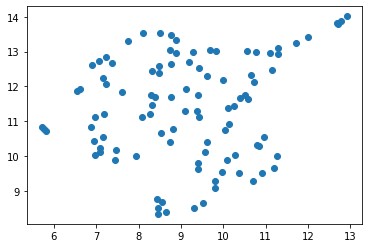

In [30]:
'''Le pasas las dos columnas y te las pintas. Así parece que no hay un patrón claro, así que es mejor hacer el embedding con la matriz de dinstancia que hay entre las pelis (el paso de instancia del coseno)'''
plt.scatter(embedding[:,0], embedding[:,1]);

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
'''Uno es que se parecen mucho las sinopsis y cero es que no se parecen nada. Si le das las vuelta con el 1- consigues esa matriz de distancia. Y entonces le haces el embedding a esta en vez de a todo el dataset.'''
cosine_similarity(tfidf_matrix)

array([[1.        , 0.12859661, 0.11729979, ..., 0.24354654, 0.11870794,
        0.12796905],
       [0.12859661, 1.        , 0.22796813, ..., 0.19083543, 0.16300172,
        0.10788849],
       [0.11729979, 0.22796813, 1.        , ..., 0.19076614, 0.14687652,
        0.24178812],
       ...,
       [0.24354654, 0.19083543, 0.19076614, ..., 1.        , 0.29509628,
        0.07668809],
       [0.11870794, 0.16300172, 0.14687652, ..., 0.29509628, 1.        ,
        0.12035997],
       [0.12796905, 0.10788849, 0.24178812, ..., 0.07668809, 0.12035997,
        1.        ]])

In [40]:
embedding = umap.fit_transform(dist)

In [41]:
embedding[:5,:]

array([[ 0.8808166,  7.2704816],
       [ 3.7856798,  4.743576 ],
       [-0.3553034,  3.6196856],
       [ 3.3003893,  6.1176476],
       [ 5.2534943,  3.9119418]], dtype=float32)

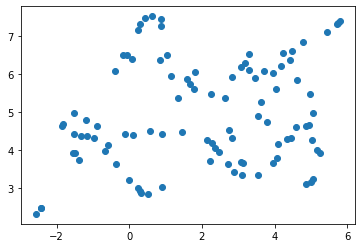

In [42]:
'''Se nota la diferencia en la representación al pasar la matriz frente a la anterior'''
plt.scatter(embedding[:,0], embedding[:,1]);

In [ ]:
##Otra técnica de clasterización, HDBSCAN. Otro algortimo no supervisado que va a buscar y encontrar clusteres en tus datos y los agrupa, pero sin etiqueta, claro, es de cluster

In [44]:
'''
Ya tenemos el embedding, que son un par de columnas. Empezamos:
Me defino un cluster y le decimos que los meta en cinco clusters mínimo, aunque puede que saque alguno más por los que no puede clasificar (los -1)
Después se le pasa a embedding el clustering con fit_predict
Y al final vemos con unique cuántas categorías ha hecho. También podemos ver la clasificación completa
'''

hdbscan = HDBSCAN(min_cluster_size=5)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([ 2,  3,  0,  4, -1,  5,  1])

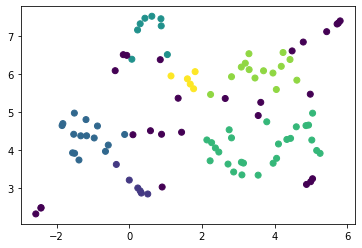

In [45]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [46]:
'''Ahora que ya hemos clusterizado, podemos rearmar un dataset enel que tenemos el título, la sinopsis y el claster al que pertenecen'''
films = pd.DataFrame({'cluster': clustering, 'title': titles, 'synopsis': synopses})

In [48]:
films.head()

,cluster,title,synopsis
0,2,The Godfather,Plot [edit] [ [ edit edit ] ] \n On ...
1,3,The Shawshank Redemption,Plot [edit] [ [ edit edit ] ] \n In ...
2,0,Schindler's List,Plot [edit] [ [ edit edit ] ] \n In ...
3,4,Raging Bull,Plot [edit] [ [ edit edit ] ] \n In ...
4,3,Casablanca,Plot [edit] [ [ edit edit ] ] \n It ...


In [49]:
'''Jugamos un poco con ello y nos sacamos el top del cluster numero 0'''

films[films['cluster'] == 0].title

2                       Schindler's List
37                            Unforgiven
49                                  Jaws
52    Butch Cassidy and the Sundance Kid
53      The Treasure of the Sierra Madre
56                             High Noon
Name: title, dtype: object

In [52]:
'''Por otra parte, podemos empezar a operar con las palabras que hemos tokenizado'''

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
0,0.0,0.064639,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.053967,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.07811,0.062870,0.159100,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.074787,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.091133,0.073637,0.0,0.00000,0.133108,0.000000,0.0
2,0.0,0.073228,0.000000,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.0,...,0.0,0.0,0.000000,0.000000,0.197012,0.0,0.00000,0.000000,0.000000,0.0
3,0.0,0.000000,0.069901,0.089895,0.0,0.085550,0.000000,0.000000,0.128654,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.06207,0.000000,0.189641,0.0
4,0.0,0.069514,0.000000,0.081106,0.0,0.077186,0.075976,0.000000,0.000000,0.0,...,0.0,0.0,0.079747,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0


In [53]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

get_df_from_cluster(0)

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
2,0.0,0.073228,0.0,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.000000,...,0.00000,0.000000,0.0,0.0,0.197012,0.000000,0.0,0.0,0.0,0.000000
37,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.102334,0.093631,0.000000,0.000000,...,0.06371,0.000000,0.0,0.0,0.000000,0.119717,0.0,0.0,0.0,0.044323
49,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.098682,0.000000,0.075383,0.218212,...,0.00000,0.097165,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.085481
52,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.080869,0.073991,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.000000,0.094605,0.0,0.0,0.0,0.000000
53,0.0,0.000000,0.0,0.120766,0.0,0.000000,0.113127,0.000000,0.000000,0.125078,...,0.00000,0.000000,0.0,0.0,0.000000,0.132343,0.0,0.0,0.0,0.000000
56,0.0,0.077975,0.0,0.000000,0.0,0.000000,0.085223,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.0,0.000000,0.099698,0.0,0.0,0.0,0.000000


In [54]:
'''Estas son las palabras top de lsa películas del claster 0,porque ha agrupado parece ser las que son de tipo bélico'''

top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

town      1.631175
little    1.024875
killed    0.885063
train     0.793345
kill      0.765340
dtype: float64

In [55]:
films[films['cluster'] == 0].title

2                       Schindler's List
37                            Unforgiven
49                                  Jaws
52    Butch Cassidy and the Sundance Kid
53      The Treasure of the Sierra Madre
56                             High Noon
Name: title, dtype: object

In [56]:
'''Podmeos ver el claster 1 a ver qué trae'''
top_words_cluster = get_df_from_cluster(1).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

army        2.281390
general     2.264080
battle      2.033972
soldiers    1.965095
war         1.865975
dtype: float64

In [57]:
films[films['cluster'] == 1].title

10                                   Lawrence of Arabia
19                                            Star Wars
24                         The Bridge on the River Kwai
29    Dr. Strangelove or: How I Learned to Stop Worr...
31                                       Apocalypse Now
33        The Lord of the Rings: The Return of the King
34                                            Gladiator
36                                  Saving Private Ryan
48                                               Patton
50                                           Braveheart
55                                              Platoon
57                                   Dances with Wolves
62                       All Quiet on the Western Front
79                                                Shane
88                                           Stagecoach
Name: title, dtype: object

In [ ]:
'''Debería cambiar cada vez que lo corres teniendo en cuenta que hemos puesto el random state en el UMAP, pero al menos sí tendrían que ser resultados parecidos. O se puede fijar'''

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>